# QPAD result visualization

In [14]:
from importlib import reload
import numpy as np
from normalize import *
import pyVisQP
ndump = 15
dirname = '..'

def sigmoid(z,a):
    return 1 / (1 + np.exp(-z/a))

## 1. Plasma and beam density
### angle = 0 (xz plane)

In [5]:
angle = 0

# Plot the charge density of plasma and beam
filename1 = dirname +'/Species1/Charge/Merged_angle_'+ str(angle) +'/charge_'+str(ndump).zfill(8)+'.h5'
filename2 = dirname +'/Beam1/Charge/Merged_angle_'+ str(angle) +'/charge_'+str(ndump).zfill(8)+'.h5'
filename3 = dirname +'/Beam2/Charge/Merged_angle_'+ str(angle) +'/charge_'+str(ndump).zfill(8)+'.h5'
filenameList = [filename1,filename2,filename3]
scaleList = [1,1,1]
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = None)


interactive(children=(FloatRangeSlider(value=(-5.0, 0.0), continuous_update=False, description='Colorbar:', ma…

### angle = 90 (yz plane)

In [3]:
angle = 90

# Plot the charge density of plasma and beam
filename1 = dirname +'/Species1/Charge/Merged_angle_'+ str(angle) +'/charge_'+str(ndump).zfill(8)+'.h5'
filename2 = dirname +'/Beam1/Charge/Merged_angle_'+ str(angle) +'/charge_'+str(ndump).zfill(8)+'.h5'
filename3 = dirname +'/Beam2/Charge/Merged_angle_'+ str(angle) +'/charge_'+str(ndump).zfill(8)+'.h5'
filenameList = [filename1,filename2,filename3]
scaleList = [1,1,1]
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = None)

interactive(children=(FloatRangeSlider(value=(-5.0, 0.0), continuous_update=False, description='Colorbar:', ma…

## 2. Accelerating field: $E_z$
### angle = 0 (xz plane)

In [13]:
angle = 0
# Plot the accelerating field with transverse lineout
filename = dirname +'/Fields/Ez/Merged_angle_'+ str(angle) +'/ez_'+str(ndump).zfill(8)+'.h5'
filenameList = [filename]
pyVisQP.makeplot(filenameList,LineoutDir = 'longitudinal',specify_title = '$E_z \; [mc\omega_p / e]$')
pyVisQP.makeplot(filenameList,LineoutDir = 'transverse',specify_title = '$E_z \; [mc\omega_p / e]$')

interactive(children=(FloatRangeSlider(value=(-1.0, 1.0), continuous_update=False, description='Colorbar:', ma…

interactive(children=(FloatRangeSlider(value=(-1.0, 1.0), continuous_update=False, description='Colorbar:', ma…

### angle = 90 (yz plane)

In [15]:
angle = 90
# Plot the accelerating field with transverse lineout
filename = dirname +'/Fields/Ez/Merged_angle_'+ str(angle) +'/ez_'+str(ndump).zfill(8)+'.h5'
filenameList = [filename]
pyVisQP.makeplot(filenameList,LineoutDir = 'longitudinal',specify_title = '$E_z \; [mc\omega_p / e]$')
pyVisQP.makeplot(filenameList,LineoutDir = 'transverse',specify_title = '$E_z \; [mc\omega_p / e]$')

interactive(children=(FloatRangeSlider(value=(-1.0, 1.0), continuous_update=False, description='Colorbar:', ma…

interactive(children=(FloatRangeSlider(value=(-1.0, 1.0), continuous_update=False, description='Colorbar:', ma…

## 3. Focusing force
### angle = 0 (xz plane)

In [19]:
angle = 0

In [21]:
# Plot the x component of the focusing force : Fx with transverse and longitudinal lineout
filename1 = dirname + '/Fields/Er/Merged_angle_'+ str(angle) +'/er_'+str(ndump).zfill(8)+'.h5'
filename2 = dirname + '/Fields/Bphi/Merged_angle_'+ str(angle) +'/bphi_'+str(ndump).zfill(8)+'.h5'
filenameList = [filename1,filename2]
scaleList = [-1,1]
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = 'transverse',specify_title = '$F_x \; [mc\omega_p]$',Show_theory = 'focus')
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = 'longitudinal',specify_title = '$F_x \; [mc\omega_p]$',Show_theory = 'focus')

interactive(children=(FloatRangeSlider(value=(-1.0, 1.0), continuous_update=False, description='Colorbar:', ma…

interactive(children=(FloatRangeSlider(value=(-1.0, 1.0), continuous_update=False, description='Colorbar:', ma…

### angle = 90 (yz plane)

In [25]:
angle = 90

In [27]:
# Plot the y component of the focusing force : Fy with transverse and longitudinal lineout
filename1 = dirname + '/Fields/Er/Merged_angle_'+ str(angle) +'/er_'+str(ndump).zfill(8)+'.h5'
filename2 = dirname + '/Fields/Bphi/Merged_angle_'+ str(angle) +'/bphi_'+str(ndump).zfill(8)+'.h5'
filenameList = [filename1,filename2]
scaleList = [-1,1]
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = 'transverse',specify_title = '$F_x \; [mc\omega_p]$',Show_theory = 'focus')
pyVisQP.makeplot(filenameList,scaleList,LineoutDir = 'longitudinal',specify_title = '$F_x \; [mc\omega_p]$',Show_theory = 'focus')

interactive(children=(FloatRangeSlider(value=(-1.0, 1.0), continuous_update=False, description='Colorbar:', ma…

interactive(children=(FloatRangeSlider(value=(-1.0, 1.0), continuous_update=False, description='Colorbar:', ma…

# Calculate the emittance

In [4]:
ndump = 15
first_file_number = 0
last_file_number = 1800

### Plot the emittance evolution for a single slice in witness beam

In [5]:
pyVisQP = reload(pyVisQP)
# You cannot have any comment in qpinput.json !!!
parameters = pyVisQP.analyze_beam_data_QPAD_profile1(first_file_number = first_file_number,last_file_number = last_file_number,
                                            ndump = ndump,beam_number = 2, zVisualizeCenter = 0, slice_thickness = 2)

In file ../Beam2/Raw/raw_00000000.h5, analyzing  20.008462354441544 % particles
In file ../Beam2/Raw/raw_00000015.h5, analyzing  20.00845043059652 % particles
In file ../Beam2/Raw/raw_00000030.h5, analyzing  20.00845043059652 % particles
In file ../Beam2/Raw/raw_00000045.h5, analyzing  20.008510024606366 % particles
In file ../Beam2/Raw/raw_00000060.h5, analyzing  20.00852194848691 % particles
In file ../Beam2/Raw/raw_00000075.h5, analyzing  20.008498100740038 % particles
In file ../Beam2/Raw/raw_00000090.h5, analyzing  20.008498100740038 % particles
In file ../Beam2/Raw/raw_00000105.h5, analyzing  20.008498100740038 % particles
In file ../Beam2/Raw/raw_00000120.h5, analyzing  20.008510024606366 % particles
In file ../Beam2/Raw/raw_00000135.h5, analyzing  20.00852194848691 % particles
In file ../Beam2/Raw/raw_00000150.h5, analyzing  20.00853387238166 % particles
In file ../Beam2/Raw/raw_00000165.h5, analyzing  20.00853387238166 % particles
In file ../Beam2/Raw/raw_00000180.h5, analyzin

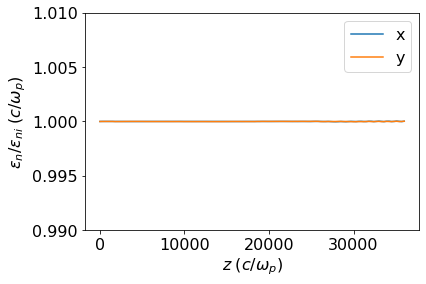

In [29]:
pyVisQP = reload(pyVisQP)
import matplotlib.pyplot as plt
plt.plot(parameters['s'], parameters['epsilon_n_x']/parameters['epsilon_n_x'][0],label='x')
plt.plot(parameters['s'], parameters['epsilon_n_y']/parameters['epsilon_n_y'][0],label='y')
plt.xlabel('$z\;(c/\omega_p)$')
plt.ylabel('$\epsilon_n / \epsilon_{ni}  \;(c/\omega_p)$')
plt.ylim([0.99,1.01])
plt.legend(loc='best')
plt.rcParams.update({'font.size': 16})
plt.show()

In [30]:
beta_mi = normalize(5,'cm',10)
beta_mf = 312.4
a = 3000
z = np.linspace(-6 * a,6 * a, 1201)
sig = sigmoid(z,a)
beta_m = (1-sig) * (beta_mi - beta_mf) + beta_mf
alpha_m = sig * (1 - sig) * (beta_mi - beta_mf) / 2 / a
n = (beta_mf / beta_m) ** 2

z = z - z[0]

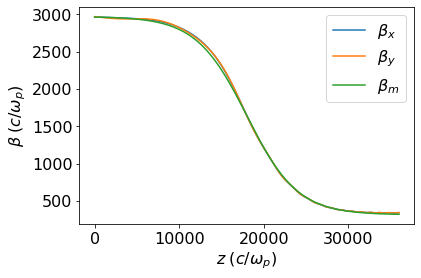

In [23]:
plt.plot(parameters['s'], parameters['beta_x'],label=r'$\beta_x$')
plt.plot(parameters['s'], parameters['beta_y'],label=r'$\beta_y$')
plt.plot(z,beta_m,label=r'$\beta_m$')
plt.xlabel('$z\;(c/\omega_p)$')
plt.ylabel(r'$\beta \;(c/\omega_p)$')
plt.legend(loc='best')
plt.rcParams.update({'font.size': 16})
plt.show()

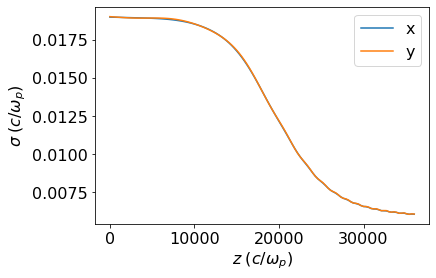

In [10]:
plt.plot(parameters['s'], parameters['sigma_x'],label='x')
plt.plot(parameters['s'], parameters['sigma_y'],label='y')

plt.xlabel('$z\;(c/\omega_p)$')
plt.ylabel(r'$\sigma \;(c/\omega_p)$')
plt.legend(loc='best')
plt.rcParams.update({'font.size': 16})
plt.show()

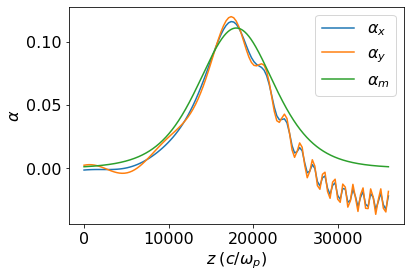

In [24]:
plt.plot(parameters['s'], parameters['alpha_x'],label=r'$\alpha_x$')
plt.plot(parameters['s'], parameters['alpha_y'],label=r'$\alpha_y$')
plt.plot(z,alpha_m,label=r'$\alpha_m$')
plt.xlabel('$z\;(c/\omega_p)$')
plt.ylabel(r'$\alpha$')
plt.legend(loc='best')
plt.rcParams.update({'font.size': 16})
plt.show()

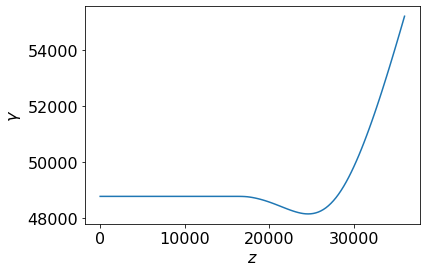

In [27]:
plt.plot(parameters['s'], parameters['energy'])

plt.xlabel('$z$')
plt.ylabel(r'$\gamma$')
plt.rcParams.update({'font.size': 16})
plt.show()

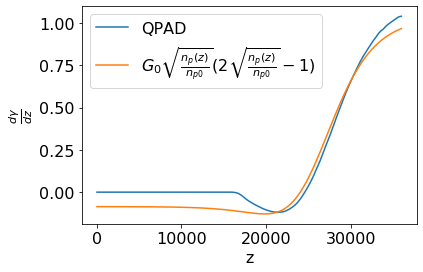

In [48]:
dgamma_dz_simulation = pyVisQP.NDiff1D(parameters['s'],parameters['energy'])

# Check Mike litos's theory
G0 = 1.03 # This parameter can be changed
n_sqrt = np.sqrt(n)
dgamma_dz_mike = G0 * n_sqrt * (2 * n_sqrt - 1)
plt.plot(parameters['s'],dgamma_dz_simulation,label='QPAD')
plt.plot(z,dgamma_dz_mike,label=r'$G_0\sqrt{\frac{n_p(z)}{n_{p0}}}(2\sqrt{\frac{n_p(z)}{n_{p0}}}-1)$')
plt.xlabel('z')
plt.ylabel(r'$\frac{d\gamma}{dz}$')
plt.legend(loc='best')
plt.rcParams.update({'font.size': 16})
plt.show()

### Plot the emittance evolution for multiple slices in witness beam

In [7]:
pyVisQP = reload(pyVisQP)

xi_s = [-1,-0.5,0,0.5,1]
slice_thickness = 0.05

parameters_xi_s = [] 

for xi in xi_s:

    parameters_xi = pyVisQP.analyze_beam_data_QPAD(first_file_number = first_file_number,last_file_number = last_file_number,
                                            ndump = ndump,beam_number = 2, zVisualizeCenter = xi, slice_thickness = slice_thickness)
    parameters_xi_s.append(parameters_xi)

In file ../Beam2/Raw/raw_00000000.h5, analyzing  0.8431755460617939 % particles
In file ../Beam2/Raw/raw_00000010.h5, analyzing  0.8432351386510979 % particles
In file ../Beam2/Raw/raw_00000020.h5, analyzing  0.8432351386510979 % particles
In file ../Beam2/Raw/raw_00000030.h5, analyzing  0.8432351386510979 % particles
In file ../Beam2/Raw/raw_00000040.h5, analyzing  0.8432351386510979 % particles
In file ../Beam2/Raw/raw_00000050.h5, analyzing  0.8432351386510979 % particles
In file ../Beam2/Raw/raw_00000060.h5, analyzing  0.8432947312404019 % particles
In file ../Beam2/Raw/raw_00000070.h5, analyzing  0.8433543238297059 % particles
In file ../Beam2/Raw/raw_00000080.h5, analyzing  0.8433548264066839 % particles
In file ../Beam2/Raw/raw_00000090.h5, analyzing  0.843355328984261 % particles
In file ../Beam2/Raw/raw_00000100.h5, analyzing  0.8433543238297059 % particles
In file ../Beam2/Raw/raw_00000110.h5, analyzing  0.843355328984261 % particles
In file ../Beam2/Raw/raw_00000120.h5, anal

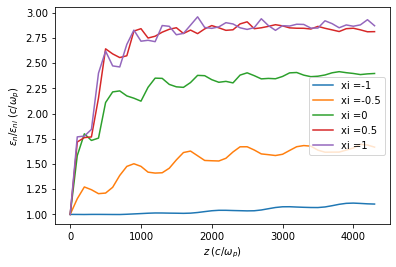

In [35]:
pyVisQP = reload(pyVisQP)
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
for i in range(len(xi_s)):
    plt.plot(parameters_xi_s[i]['s'], parameters_xi_s[i]['epsilon_n_x']/parameters_xi_s[i]['epsilon_n_x'][0],label='xi =' + str(xi_s[i]) )
plt.xlabel('$z\;(c/\omega_p)$')
plt.ylabel('$\epsilon_n / \epsilon_{ni}  \;(c/\omega_p)$')
plt.legend(loc='best')
plt.rcParams.update({'font.size': 10})
plt.show()
fig.savefig('focus_x.png', format='png')

In [31]:
np.zeros(3)

array([0., 0., 0.])

In [35]:
pyVisQP = reload(pyVisQP)
pyVisQP.NDiff1D([1,2,3],[0,2,6])

array([2., 3., 4.])